# TP04 - Convolutional models for image classification


In [1]:
!pip install --upgrade --quiet "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import TP04
TP04.check_install()

[DONE] Install ok. Version is v0.3.1


In [2]:
%matplotlib inline
import math, sys, os, torch, torchvision
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [4]:
NUM_EPOCH = 3

In [5]:
TP04.check_epochs(NUM_EPOCH)

## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

In [6]:
root_dir = './data/MNIST/'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=4)

In [7]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

# Part A - Image manipulation, convolutions

In the first part, we will perform some standard image manipulation operations by hand. In the next section, we will use torch's more efficient implementations and concentrate on the machine learning part.
We provide the function ``TP04.plot_digits(img)`` which takes either a single image or a list of images, and displays it.
Take a moment to familiarize yourself with the training images, the positions of the digits and their scales, to get a good intuition for the rest of the section.

In [8]:
images = train_set.data.to(torch.float32)
labels = train_set.targets
print(images.shape,labels.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


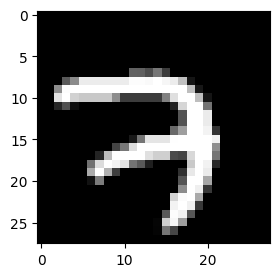

In [9]:
TP04.plot_digits(images[5000])

## A.0 - Image manipulation warmup

The digits are 28 x 28 pixels, which is relatively low quality compared to modern photographic capabilities, but already constitutes quite a lot of features when it comes to machine processing. For this reason, we often downsample (images here, and later features) to reduce
the number of dimensions if they are not necessary.

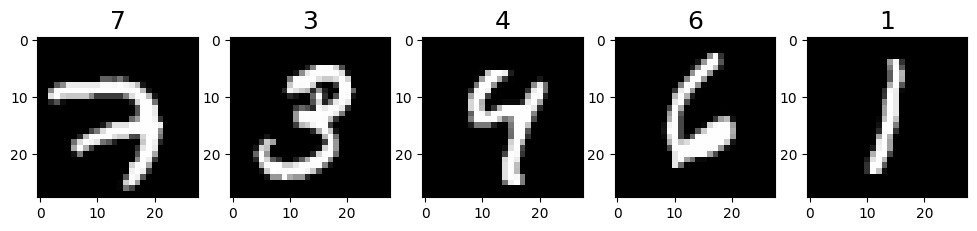

In [10]:
img_samples, label_samples = images[5000:5005], labels[5000:5005]

TP04.plot_digits(img_samples, titles=label_samples)

Observe how the function ``TP04.downsample`` shrinks the size of the image from 28x28 pixels to 7x7 by averaging
blocks of 4x4 pixels. The digits remain recognizable to some extent, and the number of dimensions has shrinked dramatically.

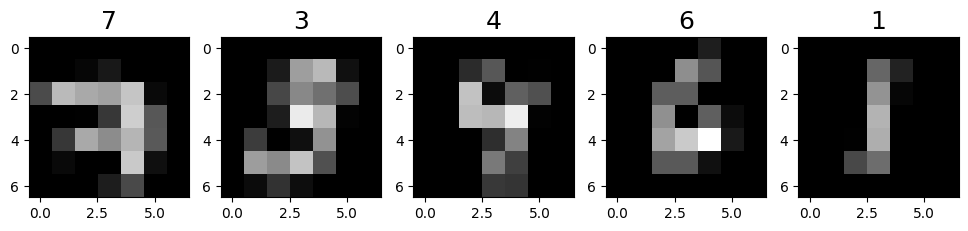

In [11]:
TP04.plot_digits(TP04.downsample(img_samples), titles=label_samples)

## A.1 - Pooling functions

Write your own ``downsample`` function, but take as argument the size of the window to shrink (4 in the previous example).
Take as an optional `mode` argument either `"avg"` or `"max"`, and perform respectively either an average of the window's pixels, or pick the maximum of the window in each case. Compute the dimensions of the image you should return ahead of time, and fill the values after.

In [12]:
def downsample(im, k, mode="avg"):
    new_img = np.zeros((im.shape[0] // k, im.shape[1] // k))
    if mode == "avg":
        init, pool = 0, lambda u, v: u + v / k ** 2
    else:
        init, pool = - np.inf, lambda u, v: max(u,v)
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            new_img[i,j] = init
            for u in range(k):
                for v in range(k):
                    new_img[i,j] = pool(new_img[i,j], im[k*i+u, k*j+v])
    return new_img

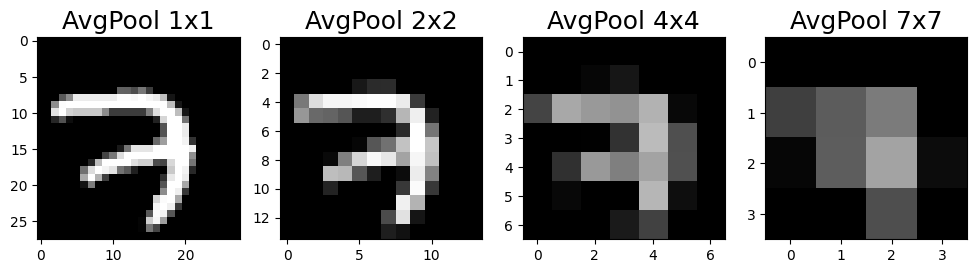

In [13]:
pool_size = [ 1, 2, 4, 7 ]
TP04.plot_digits([downsample(img_samples[0], p, mode="avg") for p in pool_size], titles=[f"AvgPool {i}x{i}" for i in pool_size])

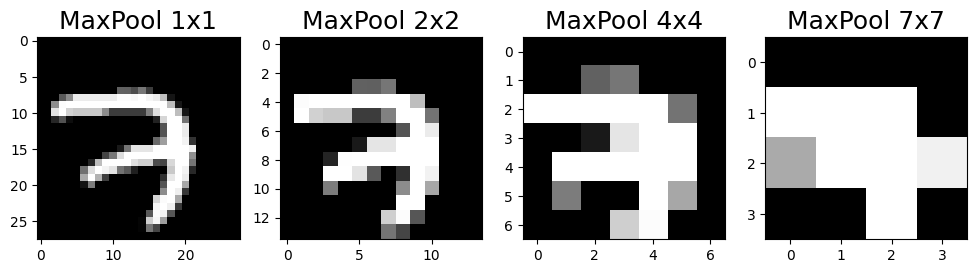

In [14]:
pool_size = [ 1, 2, 4, 7 ]
TP04.plot_digits([downsample(img_samples[0], p, mode="max") for p in pool_size], titles=[f"MaxPool {i}x{i}" for i in pool_size])

## A.2 - Convolutions

Read this article with visual explanations of [Interactive image kernels](http://setosa.io/ev/image-kernels/).

For our purposes, convolutions are a dot product of a given filter, with a local patch of the image. The convolution operation is the act of computing this dot product for every small patch of the image, in a sliding manner. This dot product with the filter is a form of
similarity / correlation between the filter and the image patch.

Here is a simple 3x3 filter, ie a 3x3 matrix (see [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples)

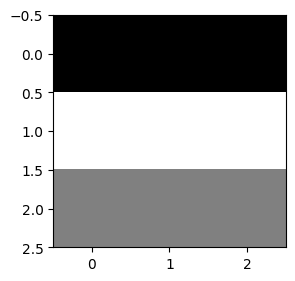

In [15]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

TP04.plot_digits(top)

Compute the convolution of the `top` filter with an image in the `correlate` function. For a 28x28 image as input, you should get a 26x26 image as output. Be careful to correctly compute output dimensions at initialization.
Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [16]:
def correlate(img, filter):
    filter = np.array(filter)
    w, h = filter.shape
    new_img = np.zeros((img.shape[0]-(w-1), img.shape[1]-(h-1)))
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            new_img[i,j] = 0
            for u in range(w):
                for v in range(h):
                    x, y = i + u, j + v
                    new_img[i,j] += filter[u,v] * img[x,y]
    return new_img

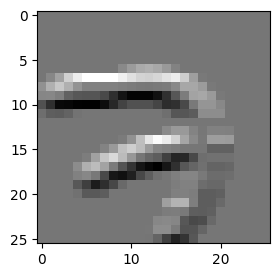

In [17]:
TP04.plot_digits(correlate(images[5000], top))

Check that this matches your intuition of correlation with the given filter. How can we leverage this to obtain an edge detection algorithm ?

## A.3 - Edge detection with convolutions

The following code computes rotations of the previous filter, and a diagonal equivalent.

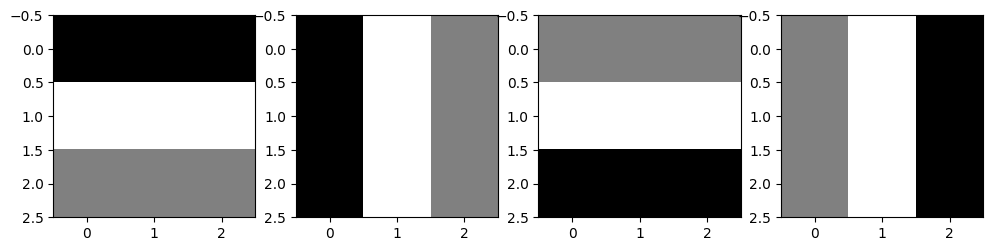

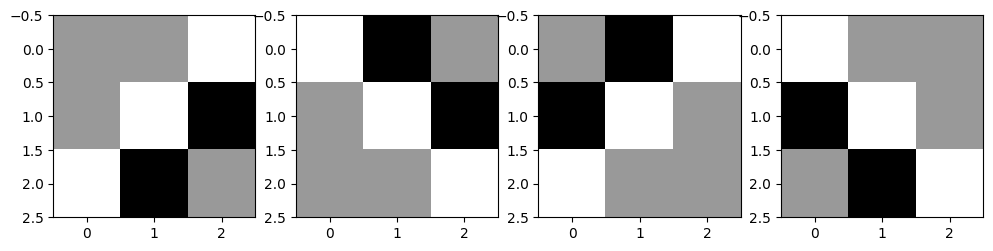

In [18]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]


straights = [ np.rot90(top,i) for i in range(4) ]
TP04.plot_digits(straights)

br=[[ 0,   0,   1],
    [ 0,   1,-1.5],
    [ 1,-1.5,   0]]

diags = [np.rot90(br,i) for i in range(4)]
TP04.plot_digits(diags)

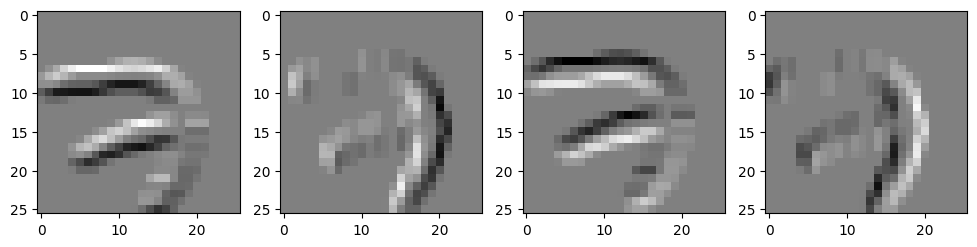

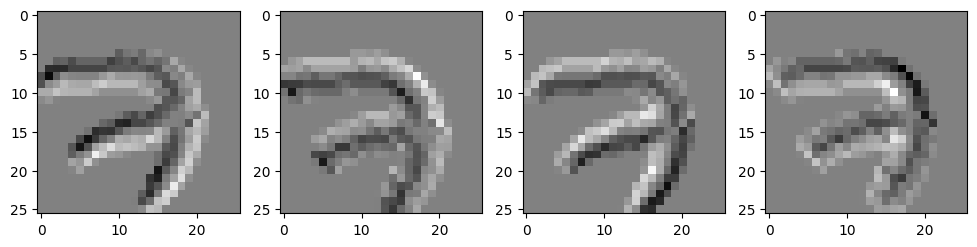

In [19]:
for rots in [ straights, diags ]:
    corrs = [ correlate(images[5000], rot) for rot in rots ]
    TP04.plot_digits(corrs)

# Part B - Digit recognition

We can now start the proper digit recognition part with a good understanding of the convolutions.
We provide a `ScoreKeeper` class to facilitate plotting of the results, and the train / test loop. You can read the following code, but you will not need to modify it.

In [20]:
score_keeper = TP04.ScoreKeeper()

In [21]:
criterion = torch.nn.CrossEntropyLoss()

def train(model, epoch, preprocess, optimizer = None, scheduler = None):
    model.to(device)
    model.train()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    if scheduler is None:
        lr_lambda = lambda i : 1 / np.sqrt(i + 2)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1, verbose=False)
    running_loss, running_acc = 0., 0
    for inputs, targets in train_loader:
        inputs, targets = preprocess(inputs.to(device)), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item()
        running_acc += torch.sum(preds == targets)
        scheduler.step() # non-standard location of scheduler step.
    n_train = len(train_loader.dataset.targets)
    print(f"[TRAIN epoch {epoch:02d}] Loss: {running_loss/n_train:.5f} Acc: {100 * running_acc/n_train:.2f}%")
    return optimizer, scheduler, running_acc/n_train

def test(model, preprocess):
    model.to(device)
    model.eval()
    running_loss, running_acc = 0., 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = preprocess(inputs.to(device)), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item()
            running_acc += torch.sum(preds == targets)
    n_test = len(test_loader.dataset.targets)
    print(f"[TEST] Loss: {running_loss/n_test:.5f} Acc: {100 * running_acc/n_test:.2f}%")
    return running_acc/n_test

The following `train_and_track` functions automatically trains your model for `NUM_EPOCH` epochs, and updates the score keeper to display the result after training. We will display the (running) train and test accuracy of your model at the end of epoch.
You will need to provide as first argument a torch model, and as second argument the preprocessing function you wish to apply to each batch of features. See the code of the `train` and `test` functions above if you need details.

In [22]:
def train_and_track(model, preprocess=lambda u: u, name="", optimizer=None, scheduler=None, keeper=score_keeper):
    keeper.clear(name)
    if model is None:
        raise RuntimeError('Model argument not defined')
    try:
        for i in range(NUM_EPOCH):
            optimizer, scheduler, train_val = train(model, i, preprocess, optimizer=optimizer, scheduler=scheduler)
            test_val = test(model, preprocess)
            keeper.register(name, train_val, test_val)
    except KeyboardInterrupt:
        print("Training interrupted by user")

# B.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

In [23]:
model = torch.nn.Linear(7*7, 10)
down_and_flat = lambda inputs: torch.nn.functional.avg_pool2d(inputs, kernel_size=4).reshape(-1, 7*7)
train_and_track(model, preprocess=down_and_flat, name="Linear - downsampled")

[TRAIN epoch 00] Loss: 0.04644 Acc: 86.46%
[TEST] Loss: 0.00402 Acc: 88.57%
[TRAIN epoch 01] Loss: 0.04099 Acc: 87.77%
[TEST] Loss: 0.00386 Acc: 88.79%
[TRAIN epoch 02] Loss: 0.04000 Acc: 88.03%
[TEST] Loss: 0.00377 Acc: 89.36%


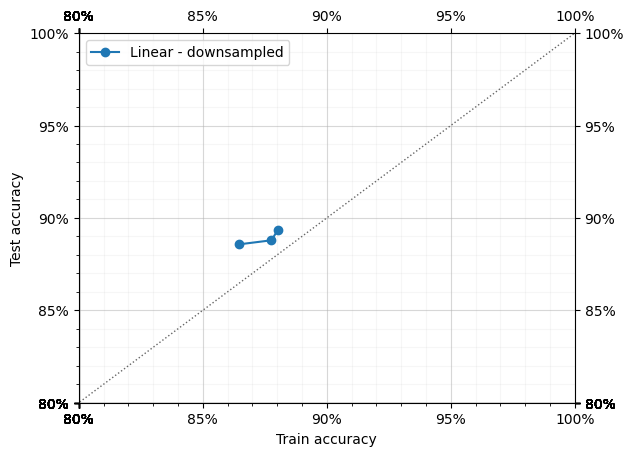

In [24]:
score_keeper.plot()

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

Compare this with a linear model taking all 28x28 pixels. Don't downsample but don't forget to flatten images in pre-processing.

In [25]:
model = torch.nn.Linear(28*28, 10)
train_and_track(model, preprocess=lambda inputs: inputs.reshape(-1, 28*28), name="Linear")

[TRAIN epoch 00] Loss: 0.06159 Acc: 89.24%
[TEST] Loss: 0.00365 Acc: 91.46%
[TRAIN epoch 01] Loss: 0.03367 Acc: 91.41%
[TEST] Loss: 0.00325 Acc: 91.81%
[TRAIN epoch 02] Loss: 0.03025 Acc: 91.97%
[TEST] Loss: 0.00301 Acc: 92.29%


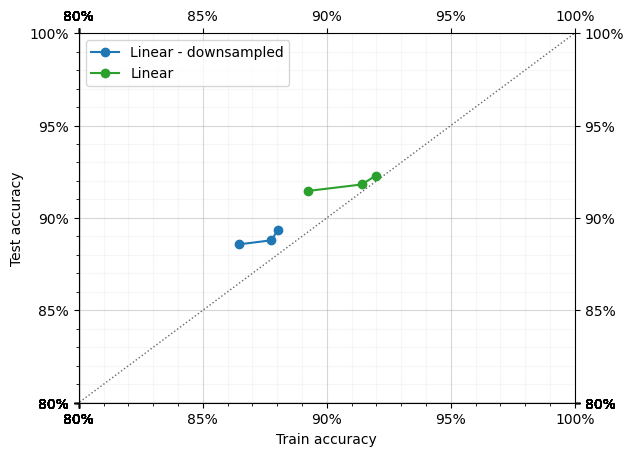

In [26]:
score_keeper.plot()

## B.2 - Random features

To push performance up, we will use a standard method which still maintains good theoretical guarantees: random features with a linear model.

Use `k = 750` random features. For each random feature, draw (statically, not every time the function is called) a random vector of 28x28 entries with a normal distribution. In the preprocessing function, take a dot product of the image with each random vector, then compute the feature as the relu of this dot product, with `torch.nn.functional.relu`. Don't forget that the preprocessing function is applied on every batch, so it should be as fast as possible, do not use python for loops.

Use a `torch.nn.Linear` model with these `k` features and compare the accuracy with the previous model.

In [27]:
k = 750
rand_w = torch.randn(28 * 28, k)

def preprocess(inputs):
    z = inputs.reshape(inputs.shape[0], -1) @ rand_w
    filtered = torch.nn.functional.relu(z)
    return filtered.reshape(inputs.shape[0], -1)

model = torch.nn.Linear(k, 10)

train_and_track(model, preprocess, "Random features")

[TRAIN epoch 00] Loss: 0.79813 Acc: 90.13%
[TEST] Loss: 0.03256 Acc: 93.26%
[TRAIN epoch 01] Loss: 0.25455 Acc: 93.57%
[TEST] Loss: 0.02335 Acc: 93.98%
[TRAIN epoch 02] Loss: 0.17772 Acc: 94.45%
[TEST] Loss: 0.02030 Acc: 94.62%


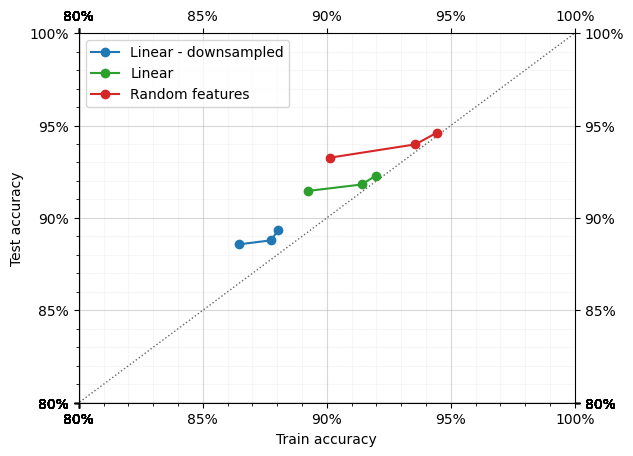

In [28]:
score_keeper.plot()

You should be able to reach above 93\% test accuracy with this strategy, and up to 96\%. Note that the learned model is still linear, so all the usual theoretical guarantees of logistic regression hold. The features are random but not learned. This is like a two-layer network where we would freeze the weights of the first layer, and can help get intuition on the good accuracies obtained with neural networks.

# B.3 - Manual convolutional features

We will now compare these random features with some manually-designed ones inspired from edge-detection algorithms.

Compute a filter-bank of dimension (8,3,3) with the rotated versions of edge-detection filters from the previous part.
Compute in the preprocessing function a convolution with the images using `torch.nn.functional.conv2d`, check the documentation for order and shapes of arguments. Then, still in pre-processing, take a relu of the resulting filtered images and apply a max-pooling operation with kernel size 2. Use a `torch.nn.Linear` model with these edge-detection-like features and compare the resulting performance.

In [29]:
filters = [ np.rot90(top,i) for i in range(4) ] + [ np.rot90(br,i) for i in range(4) ]
filters = [ torch.Tensor(f.copy())[None,:,:] for f in filters ]
filters = torch.stack(filters, dim=0)
    
def preprocess(inputs):
    filtered = torch.nn.functional.conv2d(inputs, filters)
    filtered = torch.nn.functional.relu(filtered)
    filtered = torch.nn.functional.max_pool2d(filtered, kernel_size=2)
    return filtered.reshape(inputs.shape[0], -1)

model = torch.nn.Linear(1352, 10)

train_and_track(model, preprocess, "Manual convolutional")

[TRAIN epoch 00] Loss: 0.07718 Acc: 93.83%
[TEST] Loss: 0.00294 Acc: 96.02%
[TRAIN epoch 01] Loss: 0.02163 Acc: 96.67%
[TEST] Loss: 0.00220 Acc: 96.78%
[TRAIN epoch 02] Loss: 0.01466 Acc: 97.34%
[TEST] Loss: 0.00200 Acc: 97.13%


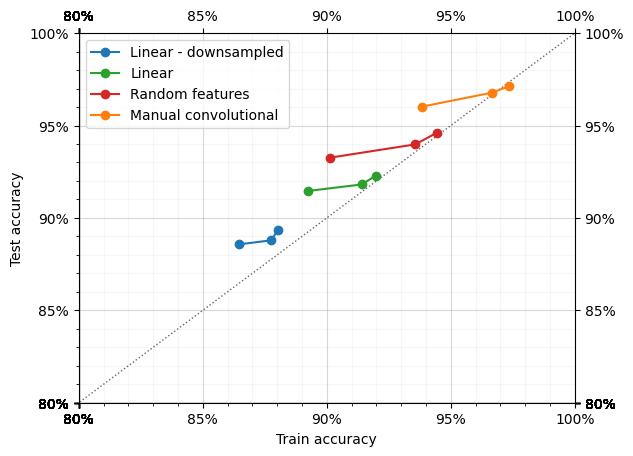

In [30]:
score_keeper.plot()

You should get above 96\%, and up to 98\% test accuracy depending on your training settings. These features are hand-crafted, but clearly much better than the previous random features. This makes sense: they were designed to take advantage of the local properties of images, and mimic knwown-meaningful edge detection operations similar to the inner workings of a human visual cortex. It is much less clear how we can craft meaningful features in other domains where we will not have decades of computer vision research to guide our ideas.

## B.4 (optional) - Convolutional random features model

Mix the previous two ideas. Try to match the manual convolutional features' accuracy with a random filter bank. How many filters and what filter width and height give good results ? Try adding an additive (random) bias after the convolution but before the relu to get a random affine operation instead of just a linear one.

In [31]:
k = 25
rand_w = torch.randn(k, 1, 3, 3)
rand_v = torch.randn(k)

def preprocess(inputs):
    filtered = torch.nn.functional.conv2d(inputs, rand_w) + rand_v[None, :, None, None]
    filtered = torch.nn.functional.relu(filtered)
    filtered = torch.nn.functional.max_pool2d(filtered, kernel_size=2)
    return filtered.reshape(inputs.shape[0], -1)

model = torch.nn.Linear(k * ((28 - 2) // 2) ** 2, 10)

train_and_track(model, preprocess, "Random conv features")

[TRAIN epoch 00] Loss: 0.48164 Acc: 92.34%
[TEST] Loss: 0.01555 Acc: 95.60%
[TRAIN epoch 01] Loss: 0.12302 Acc: 95.80%
[TEST] Loss: 0.01018 Acc: 96.40%
[TRAIN epoch 02] Loss: 0.07339 Acc: 96.79%
[TEST] Loss: 0.00682 Acc: 96.92%


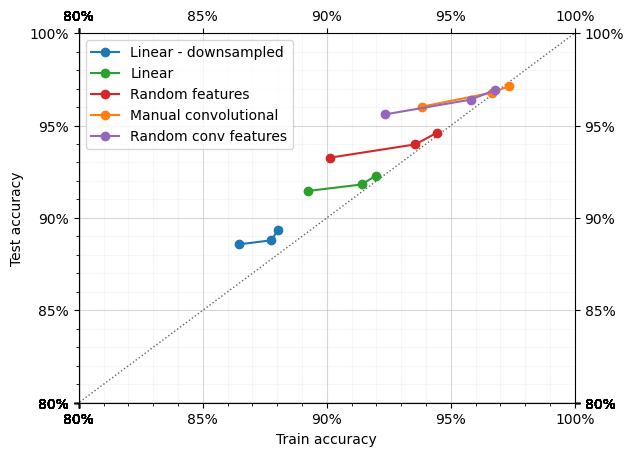

In [32]:
score_keeper.plot()

Try instead to have a convolution with the handcrafted filterbank, but follow it by a convolution with a random filter bank. Can you match the previous accuracy ? What happens if instead of just a max-pool with kernel-size 2, you take a maximum over the entire image ?
Does increasing the number of random convolutional filters compensate this dimensionality reduction ?

In [33]:
k = 150
rand_u = torch.randn(k, 8, 9, 9)
rand_v = torch.randn(k)

def preprocess(inputs):
    filtered = torch.nn.functional.conv2d(inputs, filters)
    filtered = torch.nn.functional.relu(filtered)
    filtered = torch.nn.functional.conv2d(filtered, rand_u) + rand_v[None,:,None, None]
    filtered = torch.nn.functional.relu(filtered)
    filtered = torch.nn.functional.max_pool2d(filtered, kernel_size=2)
    return filtered.reshape(inputs.shape[0], -1)

model = torch.nn.Linear(k * ((28 - 2 - (9-1)) // 2) ** 2, 10)

train_and_track(model, preprocess, "Manual + Random conv features")

[TRAIN epoch 00] Loss: 15.75228 Acc: 93.42%
[TEST] Loss: 0.36264 Acc: 96.27%
[TRAIN epoch 01] Loss: 2.85457 Acc: 97.01%
[TEST] Loss: 0.29984 Acc: 97.06%
[TRAIN epoch 02] Loss: 1.77615 Acc: 97.82%
[TEST] Loss: 0.21983 Acc: 97.67%


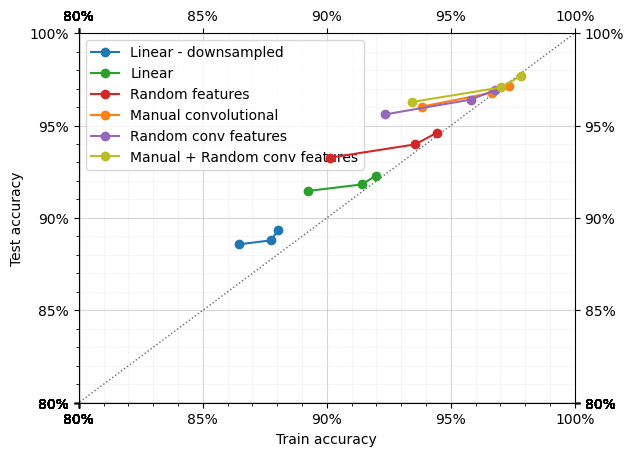

In [34]:
score_keeper.plot()

# B.4 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.

In [35]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=0)
        self.fc = torch.nn.Linear(in_features=1352, out_features=10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

model = ConvModel()

train_and_track(model, name="Conv 2-layer")

[TRAIN epoch 00] Loss: 0.01511 Acc: 95.62%
[TEST] Loss: 0.00071 Acc: 97.78%
[TRAIN epoch 01] Loss: 0.00672 Acc: 98.01%
[TEST] Loss: 0.00062 Acc: 97.89%
[TRAIN epoch 02] Loss: 0.00521 Acc: 98.46%
[TEST] Loss: 0.00056 Acc: 98.14%


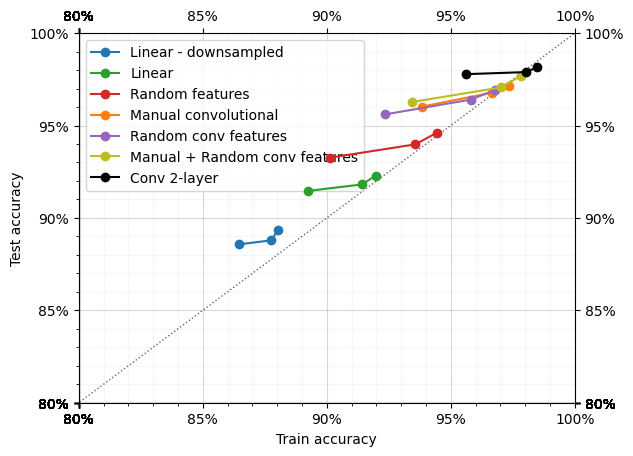

In [36]:
score_keeper.plot()

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further. 

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [37]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=0)
        self.fc0 = torch.nn.Linear(in_features=1352, out_features=h)
        self.fc1 = torch.nn.Linear(in_features=h, out_features=h)
        self.fc2 = torch.nn.Linear(in_features=h, out_features=10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2)
        x = x.reshape(x.shape[0], -1)
        x = self.fc0(x)
        x = torch.nn.functional.relu(x)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x

model = ConvDeepModel()

train_and_track(model, name="Conv 4-layer")

[TRAIN epoch 00] Loss: 0.02683 Acc: 92.15%
[TEST] Loss: 0.00112 Acc: 96.58%
[TRAIN epoch 01] Loss: 0.01011 Acc: 96.89%
[TEST] Loss: 0.00080 Acc: 97.57%
[TRAIN epoch 02] Loss: 0.00758 Acc: 97.71%
[TEST] Loss: 0.00088 Acc: 97.26%


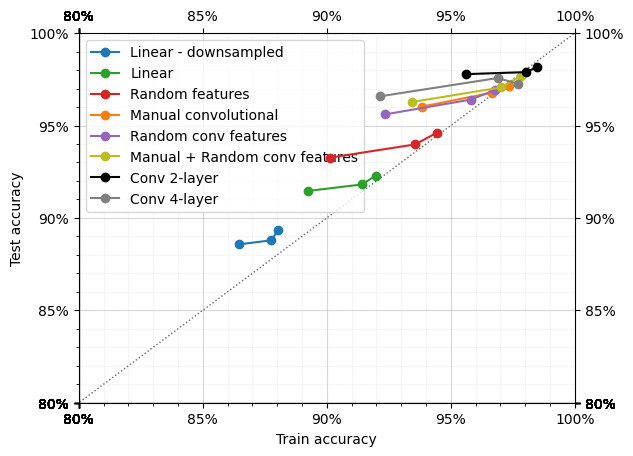

In [38]:
score_keeper.plot()

# Part C (optional) - Residual models

## C.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [39]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.fc0 = torch.nn.Linear(in_features=d, out_features=h)
        self.fc1 = torch.nn.Linear(in_features=h, out_features=d)
        
    def forward(self,x):
        z = self.fc0(x)
        z = torch.nn.functional.relu(z)
        return x + self.fc1(z)

## C.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [40]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=out, kernel_size=k, padding=0)
        d = out * ((28 - k + 1) // 2) ** 2
        self.res = [ ResidualBlock(d, h) for _ in range(l) ]
        self.fc = torch.nn.Linear(d, 10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.avg_pool2d(x, kernel_size=2)
        x = x.reshape(x.shape[0], -1)
        for l in self.res:
            x = l(x)
        return self.fc(x)

In [41]:
model = ResidualModel(l=5, h=100)

train_and_track(model, name="Conv residual")

[TRAIN epoch 00] Loss: 0.01929 Acc: 94.60%
[TEST] Loss: 0.00082 Acc: 97.44%
[TRAIN epoch 01] Loss: 0.00777 Acc: 97.69%
[TEST] Loss: 0.00069 Acc: 97.84%
[TRAIN epoch 02] Loss: 0.00597 Acc: 98.21%
[TEST] Loss: 0.00059 Acc: 98.07%


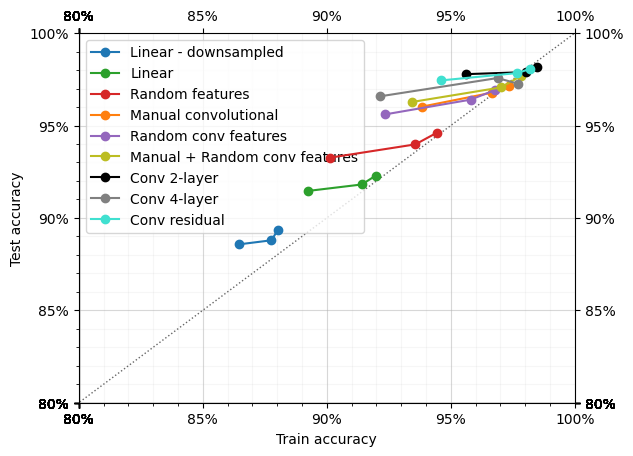

In [42]:
score_keeper.plot()

In [43]:
model = ResidualModel(l=5, h=100, out=32)
train_and_track(model, name="Conv residual - bis")

[TRAIN epoch 00] Loss: 0.03466 Acc: 93.77%
[TEST] Loss: 0.00094 Acc: 97.20%
[TRAIN epoch 01] Loss: 0.00899 Acc: 97.43%
[TEST] Loss: 0.00079 Acc: 97.81%
[TRAIN epoch 02] Loss: 0.00642 Acc: 98.18%
[TEST] Loss: 0.00064 Acc: 97.98%


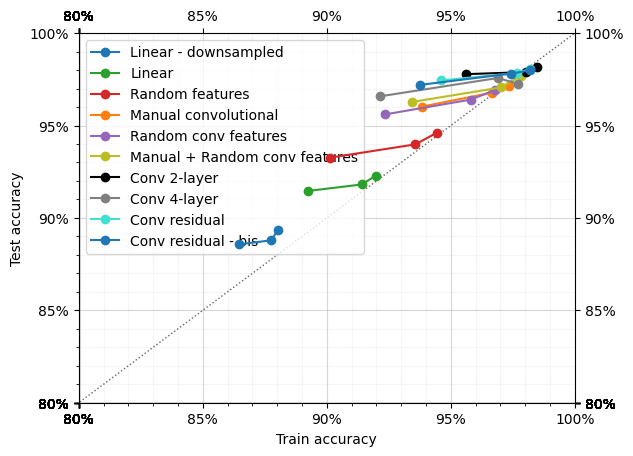

In [44]:
score_keeper.plot()

### -----